# Kaggle Playground S4e1 - Predict Bank Customer Churn
## Links
- Competition: <https://www.kaggle.com/competitions/playground-series-s4e1/overview>
- Dataset used as base of the competition's dataset: <https://www.kaggle.com/datasets/shubhammeshram579/bank-customer-churn-prediction>

## About dataset

The bank customer churn dataset is a commonly used dataset for predicting customer churn in the banking industry. It contains information on bank customers who either left the bank or continue to be a customer. The dataset includes the following attributes:

- Customer ID: A unique identifier for each customer
- Surname: The customer's surname or last name
- Credit Score: A numerical value representing the customer's credit score
- Geography: The country where the customer resides (France, Spain or Germany)
- Gender: The customer's gender (Male or Female)
- Age: The customer's age.
- Tenure: The number of years the customer has been with the bank
- Balance: The customer's account balance
- NumOfProducts: The number of bank products the customer uses (e.g., savings account, credit card)
- HasCrCard: Whether the customer has a credit card (1 = yes, 0 = no)
- IsActiveMember: Whether the customer is an active member (1 = yes, 0 = no)
- EstimatedSalary: The estimated salary of the customer
- Exited: Whether the customer has churned (1 = yes, 0 = no) 

## Load dataset

In [20]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, IsolationForest
import optuna
import xgboost as xgb
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
import lightgbm as lgb

In [2]:
df = pd.read_csv(os.path.join('datasets', 'train.csv'))
df_id = df['id']
df.drop(['id', 'CustomerId', 'Surname'], axis=1, inplace=True)

In [9]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


### Exploratory Data Analysis

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CreditScore      165034 non-null  int64  
 1   Geography        165034 non-null  object 
 2   Gender           165034 non-null  object 
 3   Age              165034 non-null  float64
 4   Tenure           165034 non-null  int64  
 5   Balance          165034 non-null  float64
 6   NumOfProducts    165034 non-null  int64  
 7   HasCrCard        165034 non-null  float64
 8   IsActiveMember   165034 non-null  float64
 9   EstimatedSalary  165034 non-null  float64
 10  Exited           165034 non-null  int64  
dtypes: float64(5), int64(4), object(2)
memory usage: 13.9+ MB


No missing values

In [7]:
y = df['Exited']

In [8]:
type(y.value_counts())

pandas.core.series.Series

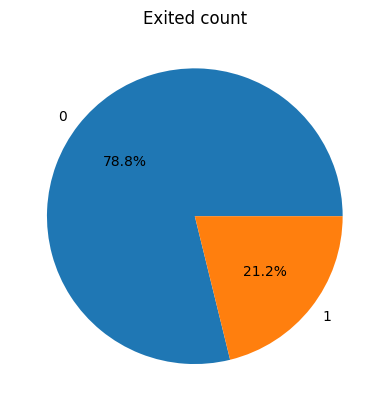

In [9]:
def plot_y(y: pd.Series):
    fig, ax = plt.subplots()
    ax.set_title('Exited count')
    y_value_counts = y.value_counts()
    y_index = y_value_counts.index
    y_values = y_value_counts.values
    ax.pie(y_values, labels=y_index, autopct='%1.1f%%')

plot_y(y)

Need class balacing.

In [10]:
num_variables = df.select_dtypes(['int64', 'float64']).drop(['HasCrCard', 'IsActiveMember'], axis=1)
num_variables

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Exited
0,668,33.0,3,0.00,2,181449.97,0
1,627,33.0,1,0.00,2,49503.50,0
2,678,40.0,10,0.00,2,184866.69,0
3,581,34.0,2,148882.54,1,84560.88,0
4,716,33.0,5,0.00,2,15068.83,0
...,...,...,...,...,...,...,...
165029,667,33.0,2,0.00,1,131834.75,0
165030,792,35.0,3,0.00,1,131834.45,0
165031,565,31.0,5,0.00,1,127429.56,0
165032,554,30.0,7,161533.00,1,71173.03,0


In [11]:
num_variables.groupby('Exited').mean()

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary
Exited,,,,,,
0,657.590710,36.560480,5.048796,51255.807752,1.615273,112084.293725
1,652.220469,43.958478,4.914378,71209.978085,1.327854,114402.496656


<Axes: >

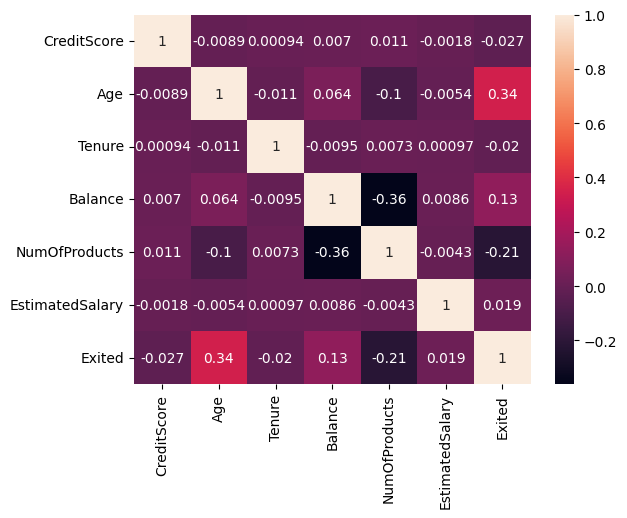

In [12]:
corrmat = num_variables.corr()
sns.heatmap(corrmat, annot=True)

<Axes: xlabel='Balance', ylabel='Age'>

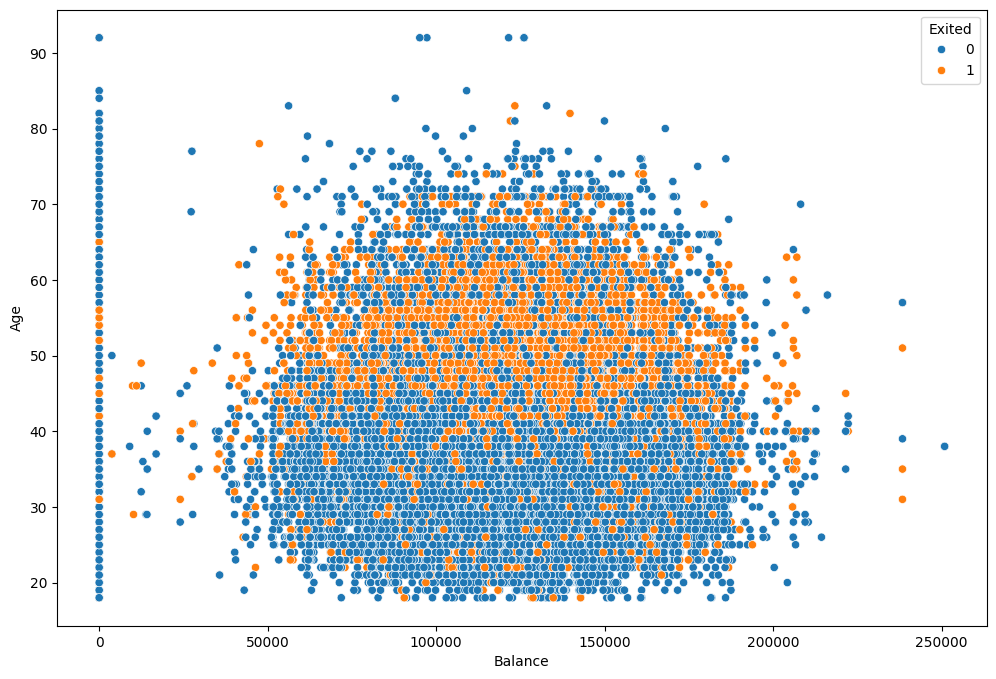

In [13]:
plt.figure(figsize=(12,8))
sns.scatterplot(num_variables, x='Balance', y='Age', hue='Exited')

<Axes: xlabel='Age', ylabel='Count'>

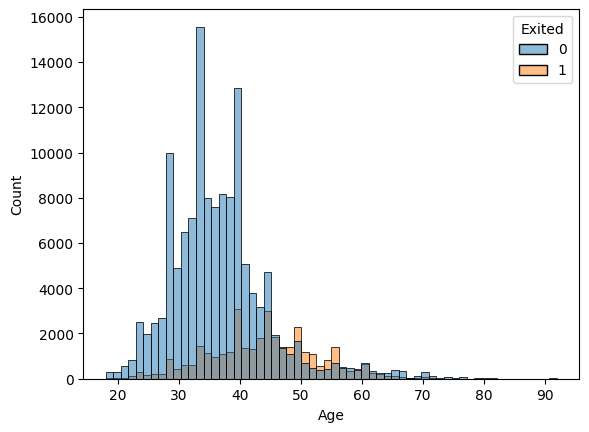

In [14]:
sns.histplot(num_variables, x='Age', hue='Exited', bins=60)

In [50]:
cat_variables = df[['Geography', 'Gender', 'HasCrCard', 'IsActiveMember', 'Exited']].astype({'Exited': 'O'})
cat_variables

,Geography,Gender,HasCrCard,IsActiveMember,Exited
0,France,Male,1.0,0.0,0
1,France,Male,1.0,1.0,0
2,France,Male,1.0,0.0,0
3,France,Male,1.0,1.0,0
4,Spain,Male,1.0,1.0,0
...,...,...,...,...,...
165029,Spain,Female,1.0,1.0,0
165030,France,Male,0.0,0.0,0
165031,France,Male,1.0,1.0,0
165032,Spain,Female,0.0,1.0,0


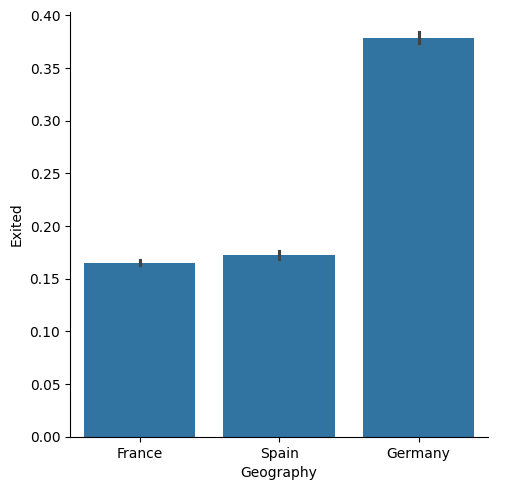

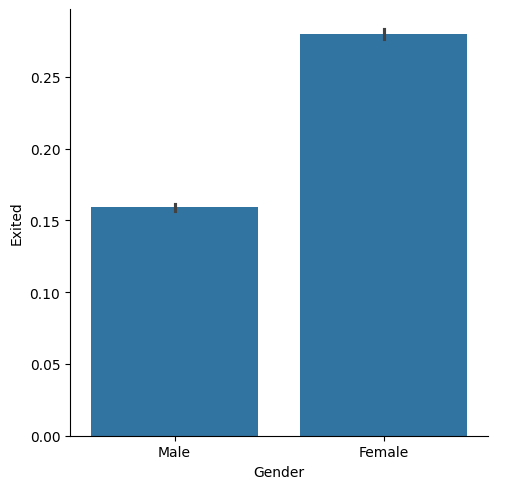

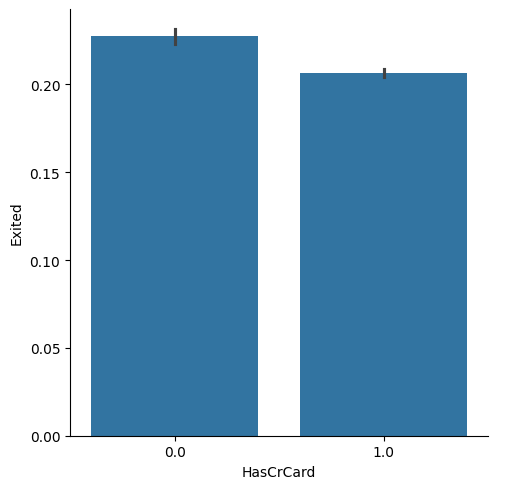

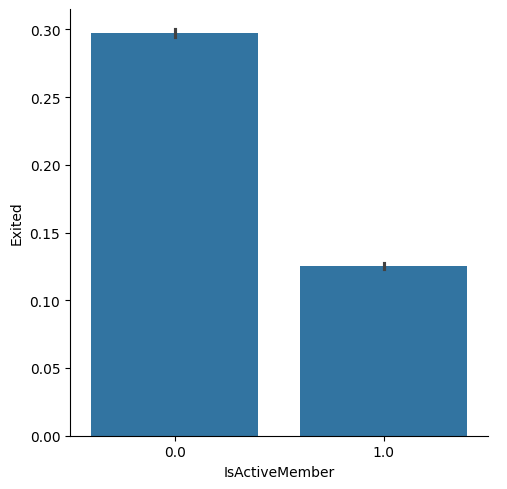

In [51]:
sns.catplot(cat_variables, kind='bar', x='Geography', y='Exited')
sns.catplot(cat_variables, kind='bar', x='Gender', y='Exited')
sns.catplot(cat_variables, kind='bar', x='HasCrCard', y='Exited')
sns.catplot(cat_variables, kind='bar', x='IsActiveMember', y='Exited')

### Models

#### Preprocessing

In [3]:
cat_variables_cols = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']
num_variables_cols = df.select_dtypes(['int64', 'float64']).drop(['HasCrCard', 'IsActiveMember','Exited'], axis=1).columns.to_list()

In [4]:
preprocessor = ColumnTransformer([('num', StandardScaler(), num_variables_cols),
                                   ('cat', OneHotEncoder(), cat_variables_cols)], remainder='drop')

In [34]:
df_trans = preprocessor.set_params(cat__drop='first').fit_transform(df)
y_trans = df['Exited']
#sm = SMOTE(random_state=42)
#df_trans, y_trans = sm.fit_resample(df_trans, df['Exited'])

In [18]:
df_trans.shape

(260226, 11)

In [6]:
preprocessor.get_feature_names_out()

array(['num__CreditScore', 'num__Age', 'num__Tenure', 'num__Balance',
       'num__NumOfProducts', 'num__EstimatedSalary',
       'cat__Geography_Germany', 'cat__Geography_Spain',
       'cat__Gender_Male', 'cat__HasCrCard_1.0',
       'cat__IsActiveMember_1.0'], dtype=object)

In [14]:
feature_names = num_variables_cols + preprocessor.transformers_[1][1].get_feature_names_out().tolist()

In [15]:
feature_names

['CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'EstimatedSalary',
 'Geography_Germany',
 'Geography_Spain',
 'Gender_Male',
 'HasCrCard_1.0',
 'IsActiveMember_1.0']

In [24]:
df_trans.shape

(165034, 11)

#### Logistic Regression

In [107]:
lr_clf = LogisticRegression(random_state=123, class_weight='balanced')

In [109]:
y_pred = cross_val_predict(lr_clf, X=df_trans, y=y_trans, cv=5, method='predict_proba')[:,1]
y_pred

array([0.24150929, 0.08665723, 0.35578857, ..., 0.15241632, 0.2356091 ,
       0.32288556])

In [110]:
y_pred_class = cross_val_predict(lr_clf, X=df_trans, y=df['Exited'], cv=5)
y_pred_class

array([0, 0, 0, ..., 0, 0, 0])

In [27]:
df['Exited']

0         0
1         0
2         0
3         0
4         0
         ..
165029    0
165030    0
165031    0
165032    0
165033    1
Name: Exited, Length: 165034, dtype: int64

In [111]:
roc_auc_score(df['Exited'], y_pred)

0.8213409582572245

In [19]:
lr_clf.fit(X=df_trans, y=df['Exited'])

LogisticRegression(class_weight='balanced', random_state=123)

In [20]:
list(zip(lr_clf.coef_[0,:], feature_names))

[(-0.06175774119383361, 'CreditScore'),
 (0.870510220469368, 'Age'),
 (-0.042492153152306124, 'Tenure'),
 (0.012523509267156733, 'Balance'),
 (-0.4039663224386844, 'NumOfProducts'),
 (0.03581892772433073, 'EstimatedSalary'),
 (1.0787293135974192, 'Geography_Germany'),
 (0.04268597860261211, 'Geography_Spain'),
 (-0.6708786355033238, 'Gender_Male'),
 (-0.20698619237455215, 'HasCrCard_1.0'),
 (-1.1842486996505412, 'IsActiveMember_1.0'),
 (0.10569028291841882, 'ZeroBalance_True')]

In [ ]:
lr_clf.intercept_

array([0.45798933])

<Axes: xlabel='Balance', ylabel='Age'>

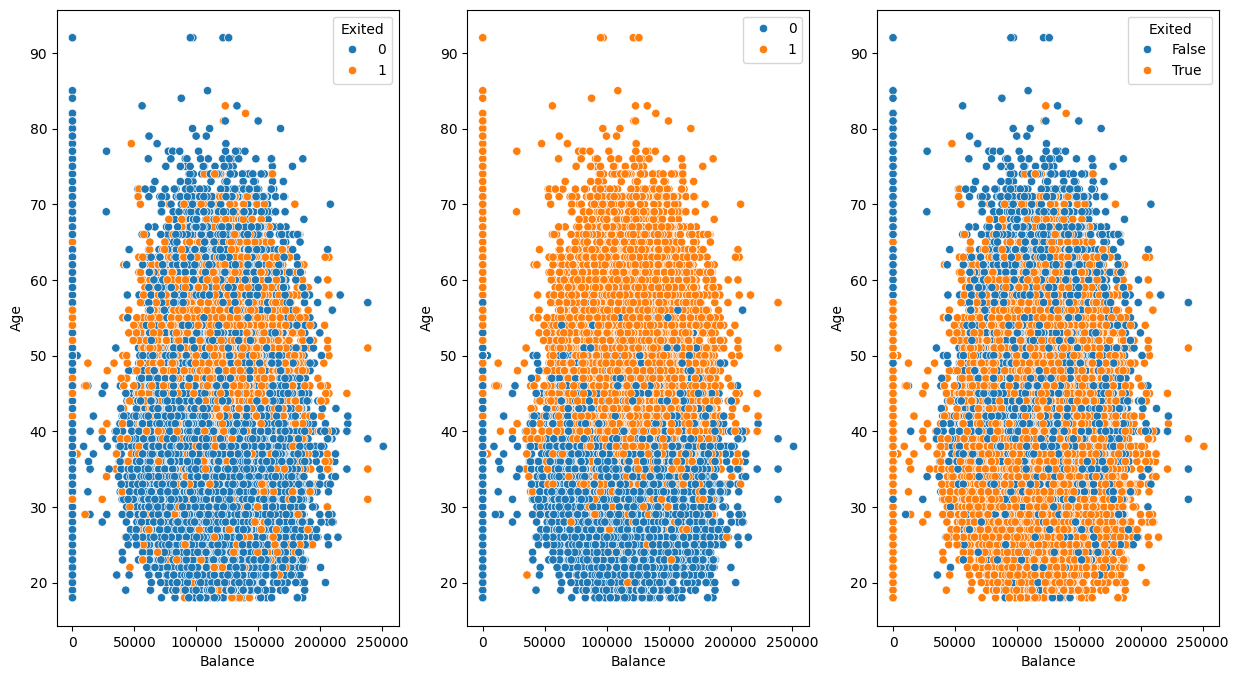

In [21]:
fig, ax = plt.subplots(1,3, figsize=(15,8))
sns.scatterplot(num_variables, x='Balance', y='Age', hue=df['Exited'], ax=ax[0])
sns.scatterplot(num_variables, x='Balance', y='Age', hue=y_pred_class, ax=ax[1])
sns.scatterplot(num_variables, x='Balance', y='Age', hue=y_pred_class==df['Exited'], ax=ax[2])

#### Decision Tree

In [22]:
dt_clf = DecisionTreeClassifier(random_state=123, class_weight='balanced', max_depth=5, min_samples_leaf=5)

In [23]:
y_pred = cross_val_predict(dt_clf, X=df_trans, y=df['Exited'], cv=5, method='predict_proba')[:,1]
y_pred

array([0.10235465, 0.04286545, 0.10235465, ..., 0.23494085, 0.37984466,
       0.67668224])

In [24]:
y_pred_class = cross_val_predict(dt_clf, X=df_trans, y=df['Exited'], cv=5)
y_pred_class

array([0, 0, 0, ..., 0, 0, 1])

In [25]:
roc_auc_score(df['Exited'], y_pred)

0.8723730709048721

<Axes: xlabel='Balance', ylabel='Age'>

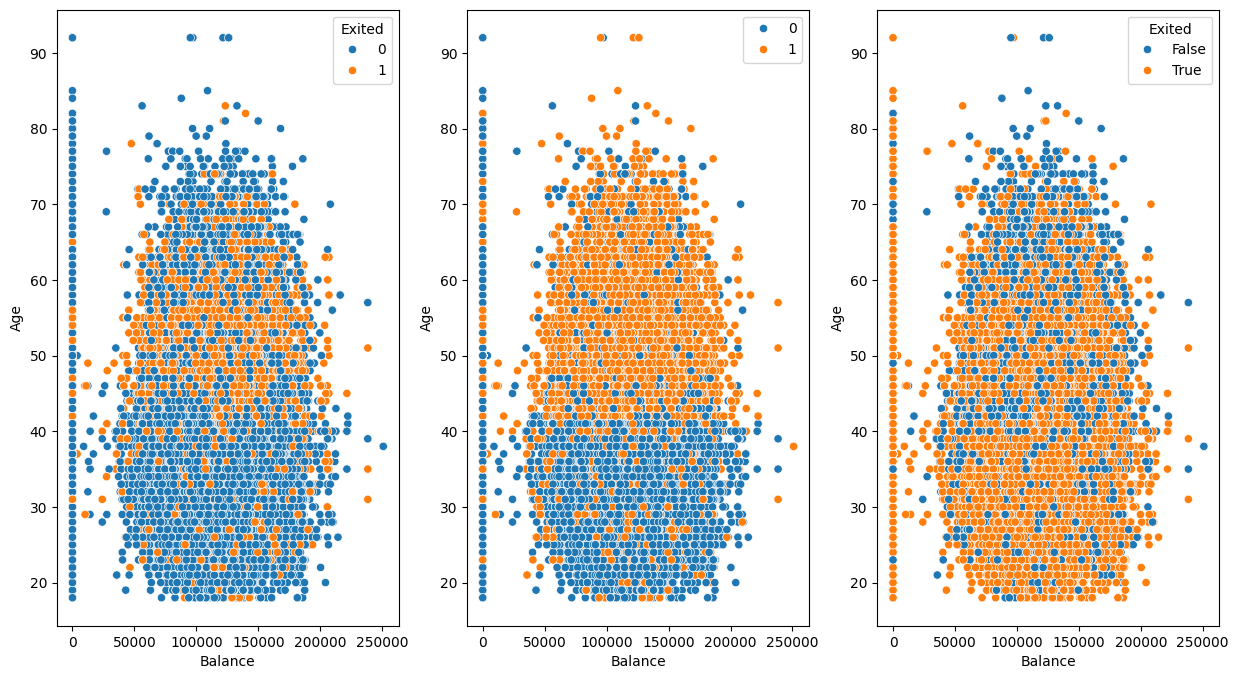

In [26]:
fig, ax = plt.subplots(1,3, figsize=(15,8))
sns.scatterplot(num_variables, x='Balance', y='Age', hue=df['Exited'], ax=ax[0])
sns.scatterplot(num_variables, x='Balance', y='Age', hue=y_pred_class, ax=ax[1])
sns.scatterplot(num_variables, x='Balance', y='Age', hue=y_pred_class==df['Exited'], ax=ax[2])

#### Random Forest Classifier

In [34]:
rf_clf = RandomForestClassifier(random_state=123, class_weight='balanced', max_depth=5)

In [36]:
y_pred = cross_val_predict(rf_clf, X=df_trans, y=df['Exited'], cv=5, method='predict_proba')[:,1]
y_pred

array([0.20531512, 0.14273214, 0.23261018, ..., 0.36156608, 0.37909973,
       0.49276394])

In [29]:
y_pred_class = cross_val_predict(rf_clf, X=df_trans, y=df['Exited'], cv=5)
y_pred_class

array([0, 0, 0, ..., 0, 0, 0])

In [35]:
cross_val_score(rf_clf, X=df_trans, y=df['Exited'], cv=5, scoring='roc_auc').mean()

0.8721496439796314

In [37]:
roc_auc_score(df['Exited'], y_pred)

0.8720530499622172

<Axes: xlabel='Balance', ylabel='Age'>

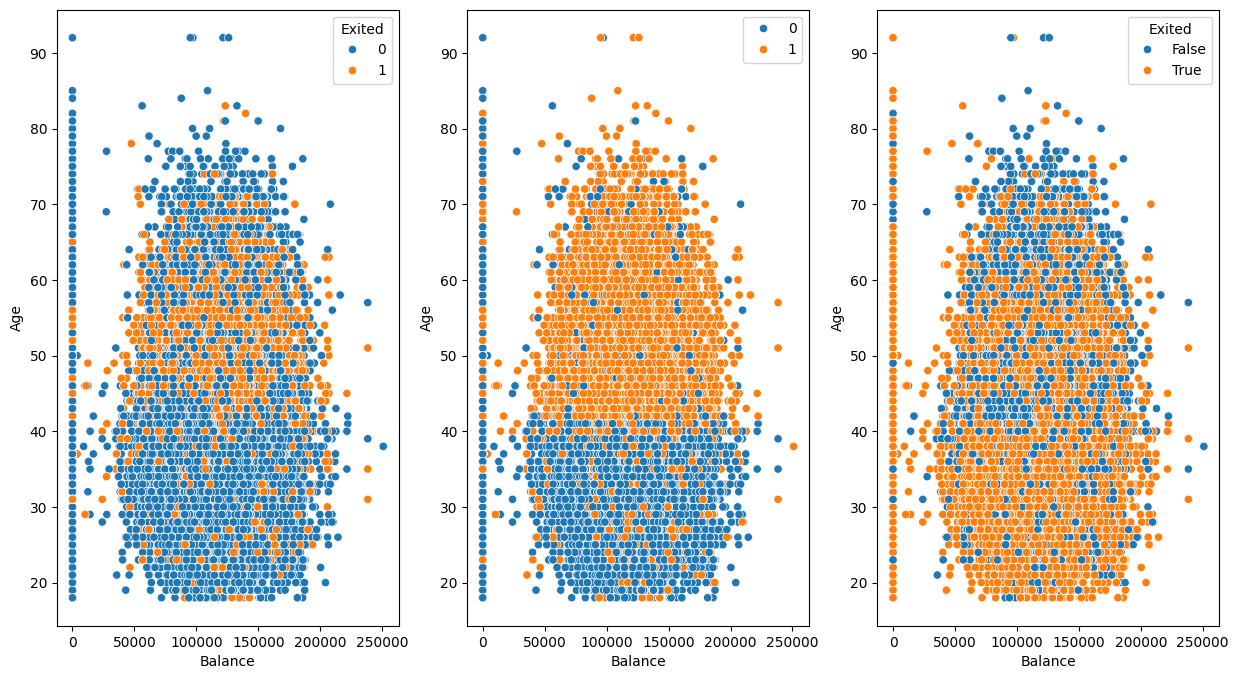

In [32]:
fig, ax = plt.subplots(1,3, figsize=(15,8))
sns.scatterplot(num_variables, x='Balance', y='Age', hue=df['Exited'], ax=ax[0])
sns.scatterplot(num_variables, x='Balance', y='Age', hue=y_pred_class, ax=ax[1])
sns.scatterplot(num_variables, x='Balance', y='Age', hue=y_pred_class==df['Exited'], ax=ax[2])

#### Hyperparameters optimization

In [115]:
def objective(trial):
    # Define the search space for hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 5, 12)
    min_samples_split = trial.suggest_float('min_samples_split', 0.01, 0.3)
    min_samples_leaf = trial.suggest_float('min_samples_leaf', 0.01, 0.3)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

    # Create the RandomForestClassifier with the suggested hyperparameters
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_features=max_features,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
        class_weight='balanced'
    )

    # Use cross-validation to evaluate the performance
    score = cross_val_score(clf, df_trans, df['Exited'], scoring='roc_auc', cv=5).mean()

    return score


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

[I 2024-01-07 19:15:55,158] A new study created in memory with name: no-name-52de58d8-6165-4e20-847a-a53bd4e01366
[W 2024-01-07 19:16:02,216] Trial 0 failed with parameters: {'n_estimators': 314, 'max_depth': 7, 'min_samples_split': 0.030517656980964487, 'min_samples_leaf': 0.2192934999835897, 'max_features': None} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/estacio/Documents/kaggle-playground-s4e1/myenv/lib/python3.8/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_18574/150346867.py", line 21, in objective
    score = cross_val_score(clf, df_trans, df['Exited'], scoring='roc_auc', cv=5).mean()
  File "/home/estacio/Documents/kaggle-playground-s4e1/myenv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 562, in cross_val_score
    cv_results = cross_validate(
  File "/home/estacio/Documents/kaggle-playground-s4e1/myenv/lib/python3.

KeyboardInterrupt: 

In [39]:
study.best_params

{'n_estimators': 461,
 'max_depth': 9,
 'min_samples_split': 0.21148560638243705,
 'min_samples_leaf': 0.2722275069615257,
 'max_features': 'log2'}

In [ ]:
study.best_trial

FrozenTrial(number=492, state=TrialState.COMPLETE, values=[0.8643607990539763], datetime_start=datetime.datetime(2024, 1, 5, 21, 49, 4, 418948), datetime_complete=datetime.datetime(2024, 1, 5, 21, 49, 47, 539919), params={'n_estimators': 155, 'max_depth': 31, 'min_samples_split': 0.010295743725836934, 'min_samples_leaf': 0.010012320708820526, 'max_features': 'log2'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=500, log=False, low=100, step=1), 'max_depth': IntDistribution(high=32, log=False, low=2, step=1), 'min_samples_split': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'min_samples_leaf': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'max_features': CategoricalDistribution(choices=('sqrt', 'log2', None))}, trial_id=492, value=None)

In [25]:
rf_clf_optuna = RandomForestClassifier(random_state=42, n_estimators=461, max_depth=9, min_samples_leaf=0.2722275069615257, min_samples_split=0.21148560638243705, max_features='log2')

#### XGBoost

In [74]:
xgb_clf = xgb.XGBClassifier(scale_pos_weight=sum(df['Exited']==0)/sum(df['Exited']==1))

score = cross_val_score(xgb_clf, df_trans, df['Exited'], cv=5, scoring='roc_auc').mean()

In [75]:
score

0.8858883155237173

In [60]:
xgb_clf.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [116]:
def objective(trial):
    # Define the search space for hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    scale_pos_weight = sum(df['Exited']==0)/sum(df['Exited']==1)
    max_depth = trial.suggest_int('max_depth', 3, 12)
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.1)
    subsample = trial.suggest_float('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.1, 1)
    gamma = trial.suggest_float('gamma', 0, 1)
    reg_lambda = trial.suggest_float('reg_lambda', 0, 5)
    reg_alpha = trial.suggest_float('reg_alpha', 0, 5)

    # Create the RandomForestClassifier with the suggested hyperparameters
    clf = xgb.XGBClassifier(eval_metric=roc_auc_score,
                            scale_pos_weight=scale_pos_weight,
                            n_estimators=n_estimators,
                            max_depth=max_depth,
                            learning_rate=learning_rate,
                            subsample=subsample,
                            colsample_bytree=colsample_bytree,
                            gamma=gamma,
                            reg_lambda=reg_lambda,
                            reg_alpha=reg_alpha)
    
    # Use cross-validation to evaluate the performance
    score = cross_val_score(clf, df_trans, df['Exited'], scoring='roc_auc', cv=5).mean()

    return score


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)

[I 2024-01-07 19:16:09,086] A new study created in memory with name: no-name-f3feb8d7-84c7-46b0-bce6-07a78c980444
[I 2024-01-07 19:16:12,281] Trial 0 finished with value: 0.8699513545833615 and parameters: {'n_estimators': 139, 'max_depth': 11, 'learning_rate': 0.06321492144988324, 'subsample': 0.19935962568922466, 'colsample_bytree': 0.17956414020810907, 'gamma': 0.8070136845366626, 'reg_lambda': 1.0338873835680369, 'reg_alpha': 2.3298533019489485, 'contamination': 0.03392509432483667}. Best is trial 0 with value: 0.8699513545833615.
[I 2024-01-07 19:16:18,425] Trial 1 finished with value: 0.8874736014246218 and parameters: {'n_estimators': 237, 'max_depth': 7, 'learning_rate': 0.09446601166416745, 'subsample': 0.7955032078824391, 'colsample_bytree': 0.3290695224606655, 'gamma': 0.6482875577512348, 'reg_lambda': 2.308159545370751, 'reg_alpha': 4.440902145082059, 'contamination': 0.0047842178816705164}. Best is trial 1 with value: 0.8874736014246218.
[I 2024-01-07 19:16:21,838] Trial 2

KeyboardInterrupt: 

In [82]:
study.best_params

{'n_estimators': 285,
 'max_depth': 5,
 'learning_rate': 0.049758494887559956,
 'subsample': 0.6788757376364833,
 'colsample_bytree': 0.6757567889591722,
 'gamma': 0.9059785851326827,
 'reg_lambda': 0.09474695836930735,
 'reg_alpha': 3.9651451215850346}

#### MPLClassifier

In [6]:
params = {'hidden_layer_sizes': 100, 'alpha': 0.0007015134766131429, 'learning_rate_init': 0.004010633215440305}
mpl_clf = MLPClassifier(hidden_layer_sizes=(100,), alpha=0.0007015134766131429, learning_rate_init=0.004010633215440305)

In [7]:
cross_val_score(mpl_clf, X=df_trans, y=y_trans, cv=5, scoring='roc_auc').mean()

0.8990348409629385

In [21]:
def objective(trial):
    # Define the search space for hyperparameters
    hidden_layer_sizes = (trial.suggest_int('hidden_layer_sizes', 4, 100))
    alpha = trial.suggest_float('alpha', 0.0001, 0.001)
    learning_rate_init = trial.suggest_float('learning_rate_init', 0.001, 0.01)

    # Create the RandomForestClassifier with the suggested hyperparameters
    clf = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,
                        alpha=alpha,
                        learning_rate_init=learning_rate_init)
    
    # Use cross-validation to evaluate the performance
    score = cross_val_score(clf, df_trans, y_trans, scoring='roc_auc', cv=5).mean()

    return score


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2024-01-08 11:01:36,117] A new study created in memory with name: no-name-2990e9a9-5f2c-45e2-8509-c0b3afdf50ce
[I 2024-01-08 11:03:46,500] Trial 0 finished with value: 0.8920921889093709 and parameters: {'hidden_layer_sizes': 21, 'alpha': 0.000415867448389624, 'learning_rate_init': 0.004738928620615374}. Best is trial 0 with value: 0.8920921889093709.
[I 2024-01-08 11:17:41,977] Trial 1 finished with value: 0.8968334955954134 and parameters: {'hidden_layer_sizes': 83, 'alpha': 0.0004204375465935655, 'learning_rate_init': 0.008523033226418538}. Best is trial 1 with value: 0.8968334955954134.
[I 2024-01-08 11:19:45,154] Trial 2 finished with value: 0.8923119101299062 and parameters: {'hidden_layer_sizes': 16, 'alpha': 0.00038407988515458933, 'learning_rate_init': 0.0062929720592554824}. Best is trial 1 with value: 0.8968334955954134.
[I 2024-01-08 11:20:31,977] Trial 3 finished with value: 0.8864484840184168 and parameters: {'hidden_layer_sizes': 6, 'alpha': 0.0008876389030552441, 'le

#### Light GBM

In [35]:
# Create a LightGBM model
lgb_clf = lgb.LGBMClassifier(
    objective='binary',
    metric='None',
    boosting_type='gbdt',
    num_leaves=20,
    learning_rate=0.05,
    feature_fraction=0.9
)

score = cross_val_score(lgb_clf, df_trans, y_trans, cv=5, scoring='roc_auc').mean()

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Number of positive: 27937, number of negative: 104090
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001163 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 861
[LightGBM] [Info] Number of data points in the train set: 132027, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211601 -> initscore=-1.315304
[LightGBM] [Info] Start training from score -1.315304
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.

In [36]:
score

0.8886444329313503

### Submission

In [9]:
df_test = pd.read_csv(os.path.join('datasets', 'test.csv'))
df_test_id = df_test['id']
df_test.drop(['id', 'CustomerId', 'Surname'], axis=1, inplace=True)
df_test = preprocessor.set_params(cat__drop='first').fit_transform(df_test)

In [37]:
clf = lgb_clf

y_pred = clf.fit(X=df_trans, y=y_trans).predict_proba(df_test)[:,1]
y_pred

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Number of positive: 34921, number of negative: 130113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001620 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 861
[LightGBM] [Info] Number of data points in the train set: 165034, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211599 -> initscore=-1.315315
[LightGBM] [Info] Start training from score -1.315315
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


array([0.02032691, 0.81575737, 0.03639948, ..., 0.02166138, 0.15561329,
       0.18513835])

In [38]:
submission = pd.DataFrame(data={'id': df_test_id, 'Exited': y_pred})
submission.head()

,id,Exited
0,165034,0.020327
1,165035,0.815757
2,165036,0.036399
3,165037,0.253587
4,165038,0.361915


In [27]:
clf.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.05,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'num_leaves': 31,
 'objective': 'binary',
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'metric': 'None',
 'feature_fraction': 0.9}

In [39]:
sorted(list(zip(clf.feature_importances_, feature_names)), reverse=True)

[(393, 'NumOfProducts'),
 (366, 'Balance'),
 (343, 'Age'),
 (195, 'IsActiveMember_1.0'),
 (184, 'Geography_Germany'),
 (150, 'Gender_Male'),
 (108, 'CreditScore'),
 (74, 'EstimatedSalary'),
 (49, 'HasCrCard_1.0'),
 (37, 'Tenure'),
 (1, 'Geography_Spain')]

In [92]:
clf.save_model('xgboost.json')

In [40]:
submission.to_csv(os.path.join('submissions','Light GBM no Class Balancing.csv'), index=False)